Processed 100 images.
Average plate width (pixels): 154.0948275862069
Average plate height (pixels): 51.025862068965516
Average number of boxes per image: 1.16


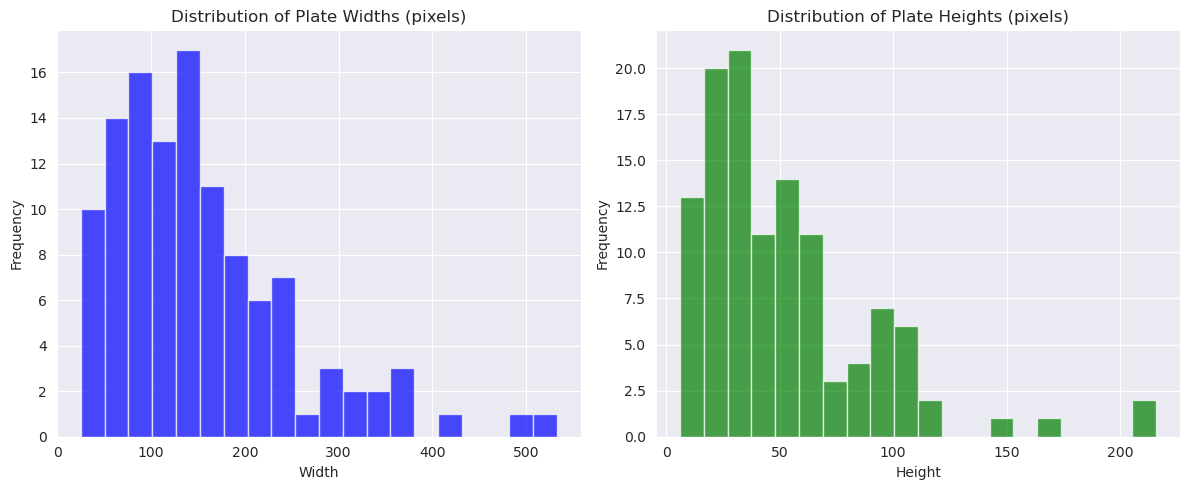

In [11]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_ground_truth_labels(csv_path):
    """
    Loads the CSV file containing ground truth labels.
    Expected CSV format: image_filename, plate_label
    Returns a dictionary mapping image filenames to their plate label.
    """
    df = pd.read_csv(csv_path)
    label_dict = dict(zip(df["image_filename"], df["plate_label"]))
    return label_dict

def convert_yolo_to_absolute(txt_line, img_width, img_height):
    """
    Converts a single line in YOLO format to absolute coordinates.
    Expected format per line:
      class x_center y_center width height
    (All coordinates are normalized [0,1].)
    Returns (xmin, ymin, xmax, ymax) in absolute pixel values.
    """
    parts = txt_line.strip().split()
    if len(parts) != 5:
        return None
    # Unpack values (ignore the first part, which is the class)
    x_center, y_center, width, height = map(float, parts[1:])
    xmin = int((x_center - width / 2) * img_width)
    ymin = int((y_center - height / 2) * img_height)
    xmax = int((x_center + width / 2) * img_width)
    ymax = int((y_center + height / 2) * img_height)
    return xmin, ymin, xmax, ymax

def get_bounding_boxes(txt_file, img_width, img_height):
    """
    Reads the txt file and converts each line from YOLO format into an absolute bounding box.
    Returns a list of (xmin, ymin, xmax, ymax) tuples.
    """
    boxes = []
    if not os.path.exists(txt_file):
        return boxes
    with open(txt_file, "r", encoding="utf-8") as f:
        for line in f:
            box = convert_yolo_to_absolute(line, img_width, img_height)
            if box:
                boxes.append(box)
    return boxes

def annotate_images(test_dir, gt_csv, annotated_dir="annotated"):
    """
    Processes each image in the test directory:
      - Loads the ground truth plate label from the CSV.
      - Reads the corresponding txt file to obtain YOLO plate coordinates.
      - Converts them to absolute coordinates.
      - Draws bounding boxes and overlays the ground truth label.
      - Saves annotated images to a designated folder.
      - Collects and prints statistics on plate sizes.
    """
    # Load ground truth labels from CSV
    label_dict = load_ground_truth_labels(gt_csv)
    
    # Create the directory for annotated images if it doesn't exist
    if not os.path.exists(annotated_dir):
        os.makedirs(annotated_dir)
    
    # For statistics
    widths = []
    heights = []
    boxes_count = []
    
    # Process each jpg image in the test directory
    image_files = glob.glob(os.path.join(test_dir, "*.jpg"))
    for img_path in image_files:
        base_name = os.path.basename(img_path)
        gt_label = label_dict.get(base_name, "N/A")
        
        # Read the image
        img = cv2.imread(img_path)
        if img is None:
            print("Could not read image:", img_path)
            continue
        
        h, w, _ = img.shape
        
        # Locate the corresponding txt file (assumes same base name, .txt extension)
        txt_file = os.path.splitext(img_path)[0] + ".txt"
        boxes = get_bounding_boxes(txt_file, w, h)
        boxes_count.append(len(boxes))
        
        # Draw each bounding box and annotate with the ground truth label
        for box in boxes:
            xmin, ymin, xmax, ymax = box
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            cv2.putText(img, gt_label, (xmin, ymin - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            widths.append(xmax - xmin)
            heights.append(ymax - ymin)
        
        # Save the annotated image
        annotated_path = os.path.join(annotated_dir, base_name)
        cv2.imwrite(annotated_path, img)
    
    # Print summary statistics
    num_images = len(image_files)
    print(f"Processed {num_images} images.")
    if widths:
        print("Average plate width (pixels):", np.mean(widths))
        print("Average plate height (pixels):", np.mean(heights))
    else:
        print("No bounding boxes were found in any images.")
    print("Average number of boxes per image:", np.mean(boxes_count))
    
    # Plot histograms for width and height distributions if data is available
    if widths and heights:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.hist(widths, bins=20, color="blue", alpha=0.7)
        plt.title("Distribution of Plate Widths (pixels)")
        plt.xlabel("Width")
        plt.ylabel("Frequency")
        
        plt.subplot(1, 2, 2)
        plt.hist(heights, bins=20, color="green", alpha=0.7)
        plt.title("Distribution of Plate Heights (pixels)")
        plt.xlabel("Height")
        plt.ylabel("Frequency")
        
        plt.tight_layout()
        plt.show()

def main():
    # Directory with test images and corresponding txt files.
    test_dir = "./testset"  
    # CSV file with ground truth plate labels, assumed to be located in the testset directory.
    gt_csv = os.path.join(test_dir, "extracted_plate_labels.csv")
    # Directory to save annotated images
    annotated_dir = os.path.join(test_dir, "annotated")
    
    annotate_images(test_dir, gt_csv, annotated_dir)

if __name__ == "__main__":
    main()



=== Detection Model Analysis ===
Total epochs: 50

-- Loss Statistics --
       train/box_loss  train/cls_loss  train/dfl_loss  val/box_loss  \
count       50.000000       50.000000       50.000000     50.000000   
mean         0.993687        0.599964        1.005475      0.906254   
std          0.166596        0.166993        0.066562      0.132646   
min          0.790300        0.419360        0.935800      0.777580   
25%          0.896260        0.507465        0.966815      0.817105   
50%          0.946750        0.554450        0.984550      0.858230   
75%          1.050512        0.649605        1.016935      0.949727   
max          1.569680        1.272280        1.247570      1.370440   

       val/cls_loss  val/dfl_loss  
count     50.000000     50.000000  
mean       0.562540      0.960058  
std        0.230435      0.056091  
min        0.401960      0.913730  
25%        0.453553      0.925412  
50%        0.497845      0.941115  
75%        0.588828      0.963840 

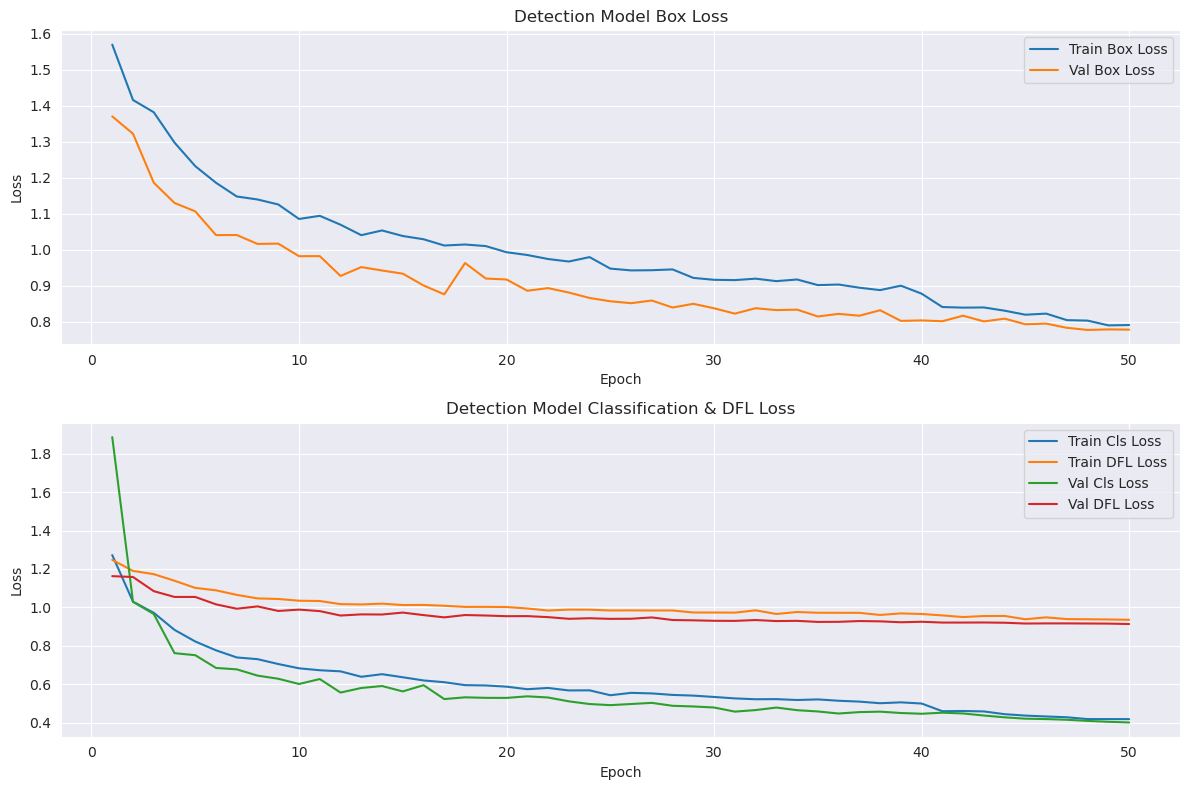

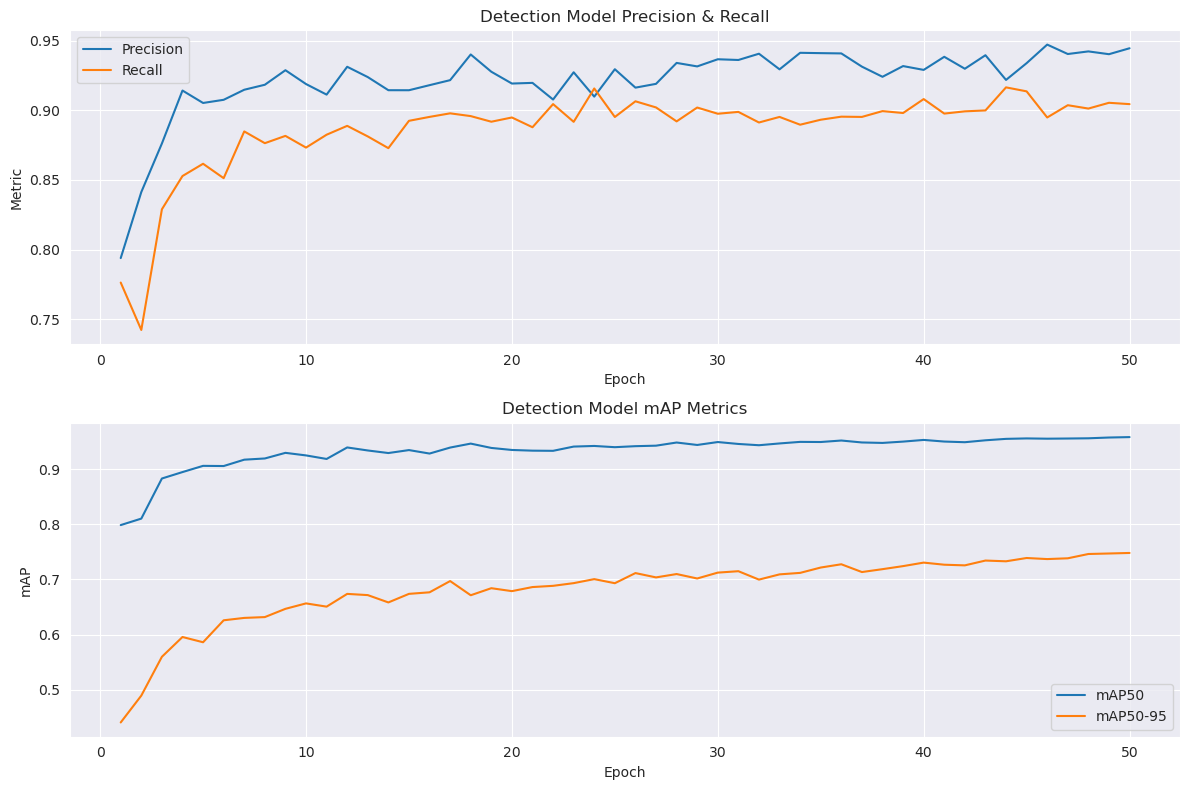


--- Detection Model Learning Rates (Last Epoch) ---
lr/pg0: 0.000218434
lr/pg1: 0.000218434
lr/pg2: 0.000218434

=== Recognition Model Analysis ===
Total epochs: 18

-- Loss Statistics --
       train/box_loss  train/cls_loss  train/dfl_loss  val/box_loss  \
count       18.000000       18.000000       18.000000     18.000000   
mean         0.364814        0.351272        0.832491      0.648709   
std          0.164319        0.331555        0.041686      0.073698   
min          0.246170        0.197480        0.808450      0.528160   
25%          0.265493        0.213615        0.811805      0.599113   
50%          0.298345        0.243070        0.816235      0.641075   
75%          0.382717        0.315043        0.832067      0.697905   
max          0.890770        1.626820        0.983000      0.794430   

       val/cls_loss  val/dfl_loss  
count     18.000000     18.000000  
mean       0.344060      0.916773  
std        0.123154      0.033390  
min        0.237100      0.

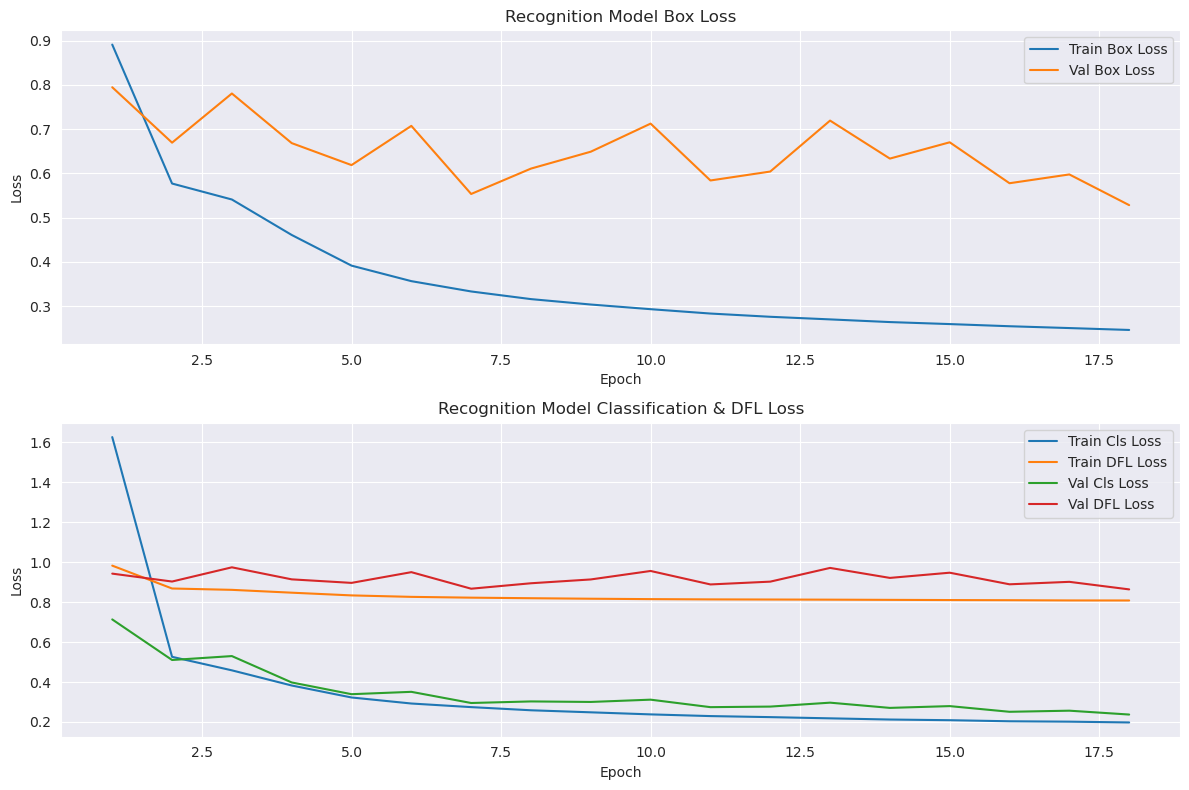

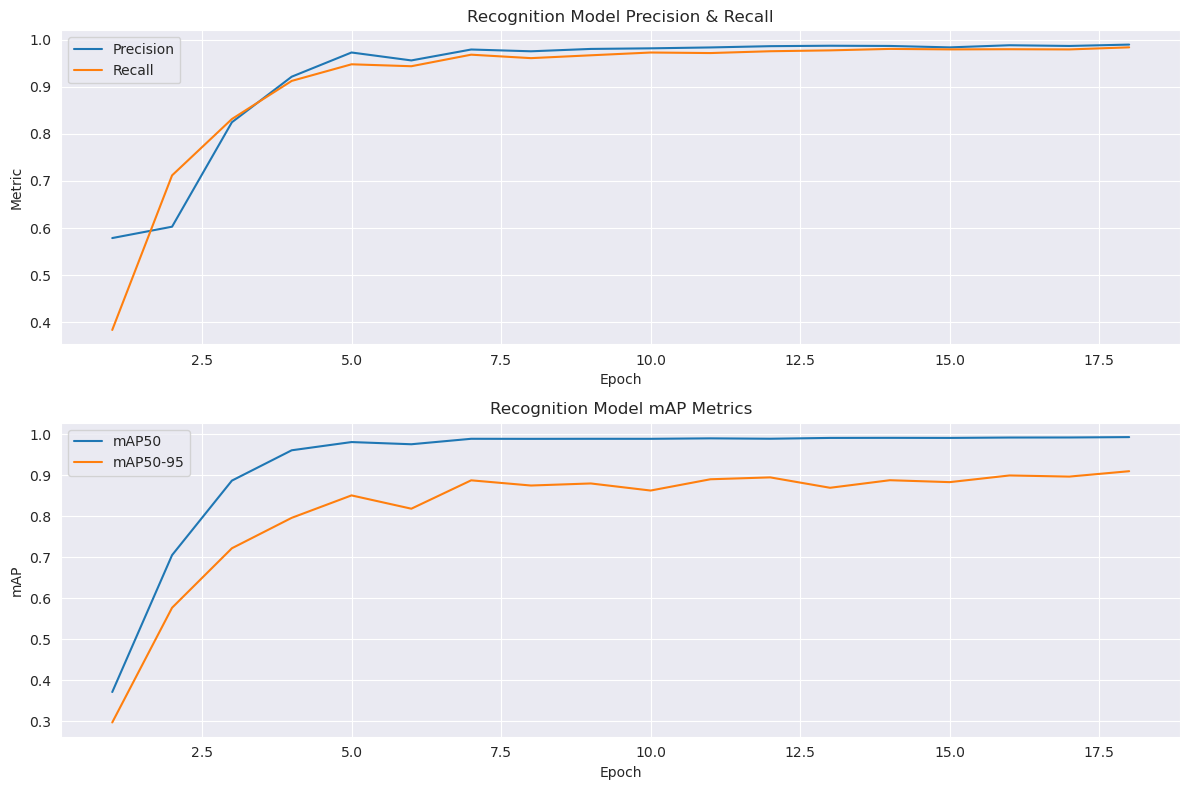


--- Recognition Model Learning Rates (Last Epoch) ---
lr/pg0: 0.006634
lr/pg1: 0.006634
lr/pg2: 0.006634

0: 640x480 1 license_plate, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 128x416 4 3s, 1 4, 2 7s, 1 ص, 12.1ms
Speed: 0.4ms preprocess, 12.1ms inference, 1.3ms postprocess per image at shape (1, 3, 128, 416)

0: 480x640 2 license_plates, 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 128x416 1 1, 1 3, 1 5, 3 6s, 1 7, 1 ل, 11.6ms
Speed: 0.6ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 128, 416)

0: 96x416 1 2, 1 4, 2 5s, 3 9s, 1 ج, 12.2ms
Speed: 0.6ms preprocess, 12.2ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 416)

0: 480x640 1 license_plate, 12.6ms
Speed: 1.6ms preprocess, 12.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 160x416 2 1s, 1 2, 1 3, 2 8s, 1 9, 1 ه‍, 12.1ms
Speed: 0.7ms pre

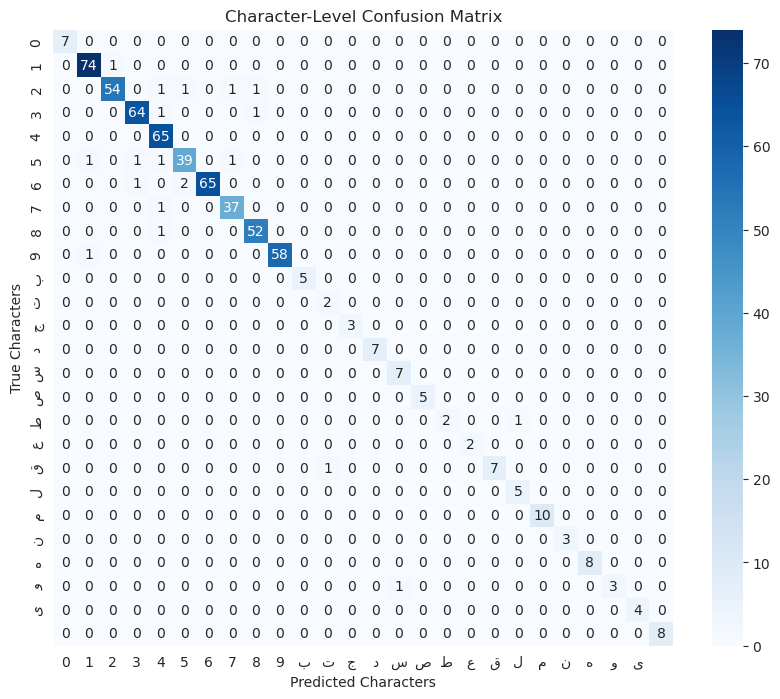


--- Character Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.97      0.99      0.98        75
           2       0.98      0.93      0.96        58
           3       0.97      0.97      0.97        66
           4       0.93      1.00      0.96        65
           5       0.93      0.91      0.92        43
           6       1.00      0.96      0.98        68
           7       0.95      0.97      0.96        38
           8       0.96      0.98      0.97        53
           9       1.00      0.98      0.99        59
           ب       1.00      1.00      1.00         5
           ت       0.67      1.00      0.80         2
           ج       1.00      1.00      1.00         3
           د       1.00      1.00      1.00         7
           س       0.88      1.00      0.93         7
           ص       1.00      1.00      1.00         5
           ط       1.00      0.67      0

In [13]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, classification_report

def load_ground_truth_labels(csv_path):
    """
    Loads the CSV file containing ground truth labels.
    Expected CSV format: image_filename, plate_label
    Returns a dictionary mapping image filenames to their plate label.
    """
    df = pd.read_csv(csv_path)
    label_dict = dict(zip(df["image_filename"], df["plate_label"]))
    return label_dict

# ==============================
# Section 1: CSV Analysis Functions
# ==============================
def plot_losses(df, title_prefix="Detection"):
    epochs = df["epoch"]
    plt.figure(figsize=(12, 8))

    # Plot training and validation box loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, df["train/box_loss"], label="Train Box Loss")
    plt.plot(epochs, df["val/box_loss"], label="Val Box Loss")
    plt.title(f"{title_prefix} Model Box Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot training and validation cls and dfl loss together
    plt.subplot(2, 1, 2)
    plt.plot(epochs, df["train/cls_loss"], label="Train Cls Loss")
    plt.plot(epochs, df["train/dfl_loss"], label="Train DFL Loss")
    plt.plot(epochs, df["val/cls_loss"], label="Val Cls Loss")
    plt.plot(epochs, df["val/dfl_loss"], label="Val DFL Loss")
    plt.title(f"{title_prefix} Model Classification & DFL Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_metrics(df, title_prefix="Detection"):
    epochs = df["epoch"]
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, df["metrics/precision(B)"], label="Precision")
    plt.plot(epochs, df["metrics/recall(B)"], label="Recall")
    plt.title(f"{title_prefix} Model Precision & Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, df["metrics/mAP50(B)"], label="mAP50")
    plt.plot(epochs, df["metrics/mAP50-95(B)"], label="mAP50-95")
    plt.title(f"{title_prefix} Model mAP Metrics")
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.legend()

    plt.tight_layout()
    plt.show()


def print_learning_rates(df, title_prefix="Detection"):
    # Print the last epoch's learning rates for each parameter group
    last_epoch = df.iloc[-1]
    print(f"\n--- {title_prefix} Model Learning Rates (Last Epoch) ---")
    print("lr/pg0:", last_epoch["lr/pg0"])
    print("lr/pg1:", last_epoch["lr/pg1"])
    print("lr/pg2:", last_epoch["lr/pg2"])


def analyze_csv(csv_path, model_type="Detection"):
    """
    Reads a CSV file with headers such as:
    epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),
    metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,
    val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
    """
    df = pd.read_csv(csv_path)
    print(f"\n=== {model_type} Model Analysis ===")
    print("Total epochs:", len(df))

    # Print summary statistics for losses and metrics
    print("\n-- Loss Statistics --")
    print(df[["train/box_loss", "train/cls_loss", "train/dfl_loss",
              "val/box_loss", "val/cls_loss", "val/dfl_loss"]].describe())

    print("\n-- Evaluation Metrics Statistics --")
    print(df[["metrics/precision(B)", "metrics/recall(B)",
              "metrics/mAP50(B)", "metrics/mAP50-95(B)"]].describe())

    # Plot losses and metrics
    plot_losses(df, title_prefix=model_type)
    plot_metrics(df, title_prefix=model_type)
    print_learning_rates(df, title_prefix=model_type)

    return df


# ==============================
# Section 2: Inference and Test Evaluation
# ==============================
# Load your YOLO models
plate_detector = YOLO("./yolo12_detection_best.pt")  # Detection model
plate_reader = YOLO("./yolo12_recognition_best.pt")  # Recognition model

# Define a mapping from class index to character.
# For a dynamic mapping, consider loading from your training pipeline.
char_to_idx = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'D': 10, 'S': 11,
               'الف': 12, 'ب': 13, 'ت': 14, 'تشریفات': 15, 'ث': 16, 'ج': 17, 'د': 18, 'ز': 19, 'س': 20, 'ش': 21,
               'ص': 22, 'ط': 23, 'ظ': 24, 'ع': 25, 'ف': 26, 'ق': 27, 'ل': 28, 'م': 29, 'ن': 30, 'ه': 31, 'ه\u200d': 32,
               'و': 33, 'پ': 34, 'ژ (معلولین و جانبازان)': 35, 'ک': 36, 'گ': 37, 'ی': 38}
# Reverse to get idx_to_char:
idx_to_char = {v: k for k, v in char_to_idx.items()}


def extract_plate_text(read_results):
    """
    Given the YOLO plate reading model output, sort character detections by x-coordinate
    and map class indices to characters using idx_to_char.
    """
    if not read_results:
        return ""

    result = read_results[0]
    boxes = result.boxes.xyxy.cpu().numpy()
    classes = result.boxes.cls.cpu().numpy()

    char_detections = []
    for box, cls in zip(boxes, classes):
        x1 = int(box[0])
        char_detections.append((x1, int(cls)))

    char_detections.sort(key=lambda x: x[0])
    plate_text = "".join(idx_to_char.get(cls, "") for _, cls in char_detections)
    return plate_text


def process_image(image_path):
    """
    Processes a single image:
      - Runs the detection model.
      - Crops detected plate and runs the recognition model.
      - Annotates the image with bounding boxes and predicted text.
    Returns the predicted plate text and annotated image.
    """
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not read image:", image_path)
        return "", None

    detection_results = plate_detector(image)
    predicted_plate = ""

    for detection in detection_results:
        for box in detection.boxes.xyxy.cpu().numpy().astype(int):
            x1, y1, x2, y2 = box
            plate_crop = image[y1:y2, x1:x2]
            read_results = plate_reader(plate_crop)
            predicted_plate = extract_plate_text(read_results)

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, predicted_plate, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return predicted_plate, image


def run_on_test_directory(test_dir, gt_csv, output_csv="results_test.csv"):
    """
    Iterates over all images in a test directory (JPEG format).
    Assumes the ground truth is in the filename (e.g., "plate_GT_ABC123.jpg").
    Saves annotated images and writes a CSV with image, ground truth, and prediction.
    Returns a DataFrame with the results.
    """
    results = []
    image_paths = glob.glob(os.path.join(test_dir, "*.jpg"))
    
    label_dict = load_ground_truth_labels(gt_csv)

    for image_path in image_paths:
        base = os.path.basename(image_path)
        gt_plate = label_dict.get(base, "N/A")

        pred_plate, annotated_image = process_image(image_path)
        if annotated_image is None:
            continue

        annotated_dir = os.path.join(test_dir, "annotated")
        if not os.path.exists(annotated_dir):
            os.makedirs(annotated_dir)
        annotated_path = os.path.join(annotated_dir, base)
        cv2.imwrite(annotated_path, annotated_image)

        results.append({
            "image": base,
            "gt_plate": gt_plate,
            "pred_plate": pred_plate
        })

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print("\nTest results saved to", output_csv)
    return results_df


def analyze_failures(results_df):
    """
    Prints a list of images where the predicted plate does not match the ground truth.
    """
    if "gt_plate" not in results_df.columns or "pred_plate" not in results_df.columns:
        print("Columns 'gt_plate' and/or 'pred_plate' not found in the results DataFrame. Available columns:",
              results_df.columns)
        return

    failed = results_df[results_df["gt_plate"] != results_df["pred_plate"]]
    print("\n--- Failed Predictions ---")
    if failed.empty:
        print("All predictions were correct!")
    else:
        for _, row in failed.iterrows():
            print(f"Image: {row['image']} | GT: {row['gt_plate']} | Predicted: {row['pred_plate']}")


# ==============================
# Section 3: Main Execution
# ==============================
if __name__ == "__main__":
    # Analyze training logs for detection and recognition models.
    detection_csv = "yolo12_detection_results.csv"  # Replace with your actual CSV path
    recognition_csv = "yolo12_recognition_results.csv"  # Replace with your actual CSV path

    df_detection = analyze_csv(detection_csv, model_type="Detection")
    df_recognition = analyze_csv(recognition_csv, model_type="Recognition")

    # Run inference on a test directory and generate results CSV.
    test_dir = "./testset"  # Replace with your test images directory
    results_df = run_on_test_directory(test_dir, "./testset/extracted_plate_labels.csv", output_csv="results_test.csv")
    print("Columns in results CSV:", results_df.columns)

    # Analyze failed predictions (for recognition task).
    analyze_failures(results_df)

    # Optionally, if you have ground truth characters for recognition, you can build a confusion matrix.
    # (Ensure your results CSV has a column for gt_plate and pred_plate with matching lengths.)
    all_true_chars = []
    all_pred_chars = []
    for _, row in results_df.iterrows():
        gt = str(row["gt_plate"])
        pred = str(row["pred_plate"])
        if len(gt) == len(pred) and len(gt) > 0:
            all_true_chars.extend(list(gt))
            all_pred_chars.extend(list(pred))

    if all_true_chars and all_pred_chars:
        labels = sorted(set(all_true_chars + all_pred_chars))
        cm = confusion_matrix(all_true_chars, all_pred_chars, labels=labels)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
        plt.xlabel("Predicted Characters")
        plt.ylabel("True Characters")
        plt.title("Character-Level Confusion Matrix")
        plt.show()

        print("\n--- Character Classification Report ---")
        print(classification_report(all_true_chars, all_pred_chars, labels=labels))
    else:
        print("Not enough data for a character-level confusion matrix.")
